# Training a Restricted Boltzmann Machine (RBM) to reconstruct MNIST images

### Author: Vincenzo Gargano, Assignment 2 - RBM reconstruction on MNIST

Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2.     Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.     Reconstruct the original test images from their hidden encoding and confront the reconstructions with the original image (use a suitable quantitative metric to assess the reconstraction quality and also choose few examples to confront visually).


# Import libraries and MNNIST dataset

In [1]:
import numpy as np
import gzip
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from RBM import *

from keras.datasets import mnist

2023-04-13 02:38:09.473340: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 02:38:10.102427: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 02:38:10.102452: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-13 02:38:12.267073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Import MNIST with Keras


In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print("Shapes are respectly train_X, train_y, test_X, test_y ", train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# For dataset that use a small number 
# of equiprobable classe we set the ideal minibatch size to number of classes
minibatch_size = 10

Shapes are respectly train_X, train_y, test_X, test_y  (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [3]:
def binarize_data(data):
    # Taking mnist train_X clump values that are greater than 0 and set them to 1
    # and the rest to 0
    data = (data > 0).astype(int)
    
    return data

In [4]:
# binarizing our dataset
train_X = binarize_data(train_X)
test_X = binarize_data(test_X)

In [5]:
def show_data(data, labels):
    """
    Show the data we're going to train.
    """
    
    fix, axes = plt.subplots(2, 10, figsize=(16, 6))
    for i in range(20):
        axes[i//10, i %10].imshow(data[i], cmap='gray');
        axes[i//10, i %10].axis('off')
        axes[i//10, i %10].set_title(f"target: {labels[i]}")
    


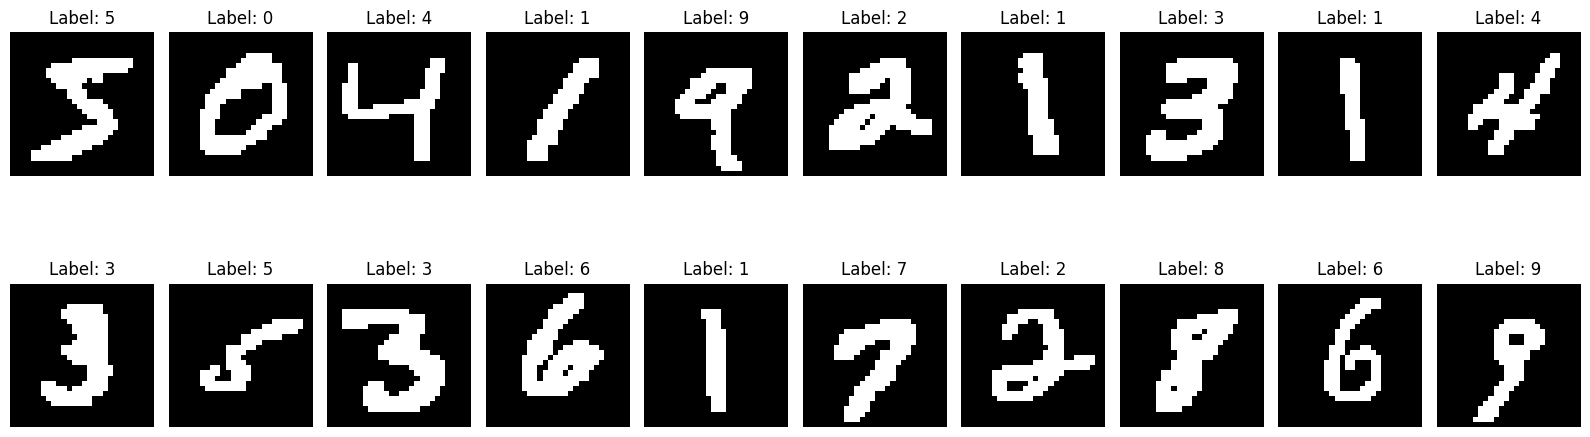

In [6]:
# Show dataset

fig, axes = plt.subplots(2, 10, figsize=(16, 6))
for i in range(20):
    axes[i//10, i %10].imshow(train_X[i], cmap='gray');
    axes[i//10, i %10].axis('off')
    axes[i//10, i %10].set_title('Label: {}'.format(train_y[i]))
    
plt.tight_layout()

# Basics of RBM

RBMs are bipartite graphs with visible units $v$ and hidden units $h$. The visible units are connected to the hidden units with weights $W_{ij}$, and the hidden units are connected to the visible units with weights $W_{ji}$. The units are binary and are connected by a symmetric matrix $W$.


The derivation of the gradient of the log-likelihood of the RBM we saw at lesson is the following:

$$
\frac{\partial \log p(v)}{\partial w_{ij}}= \sum_h p(\textbf{h}|\textbf{v})v_ih_j -\sum_{v'h} p(\textbf{v'},\textbf{h})v'_ih_j
$$

By doing some simplification the first term is the summation over hidden state vector over conditional probability of hidden states vector given visibles state vector by $v_ih_j$ this is an expectation value, so forgiven the visible vectors those we have, sample the conditionally hidden state vector over probability distribution of this quantity, so an expectation over data, the other component is summing over all states of the RBM (all possible visible and hidden vector) and we take probability of that pair and we "weight" that obervable value, this is an **expectation over the model**

$$
\mathbb{E_\mathbf{data}}[v_ih_j]-
\mathbb{E_\mathbf{model}}[v_ih_j]
$$


## Training procedure with CD-1


The procedure for training a Restricted Boltzmann Machine (RBM) can be summarized as follows:

1. Initialize the weights and biases of the RBM randomly.
2. Sample a training example from the dataset.
3. Use the positive phase to compute the probabilities of the hidden units given the visible input using the activation function of the RBM.
4. Sample a binary activation pattern for each hidden unit, based on its probability of being activated.
5. Use the negative phase to compute the probabilities of the visible units given the sampled hidden activations using the same activation function.
6. Sample a binary activation pattern for each visible unit, based on its probability of being activated.
7. Compute the difference between positive and negative phases to update weights and biases using gradint descent with a learning rate $\alpha$.

For the update we do this


$$
    \begin{equation}
        \Delta w_{i,j} = \alpha(v_i h_j^+ - v_i h_j^-)
    \end{equation}
$$

$$
\begin{equation}
        \Delta b_i = \alpha(v_i^+ - v_i^-)
    \end{equation}
$$

$$
    \begin{equation}
        \Delta c_j = \alpha(h_j^+ - h_j^-)
    \end{equation}
$$

Repeating the cycle from step 2 to 7 until we converge to a local minimum.


In [7]:
rbm = RBM(num_visible=784, num_hidden=128, epochs=20, learning_rate=0.1)

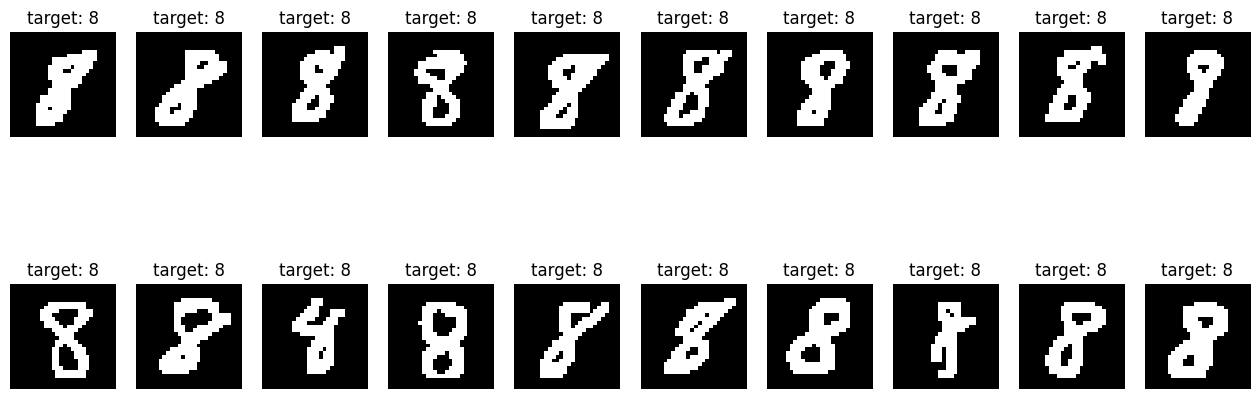

In [8]:
# Given a digit, get all the examples of that digit
digit = 8

train_X_digit = train_X[train_y == digit]
test_X_digit = test_X[test_y == digit]

show_data(train_X_digit, train_y[train_y == digit])


In [9]:

train_X_digit.shape
test_X_digit.shape
# flatten all the examples
train_X_digit = train_X_digit.reshape(train_X_digit.shape[0], -1)
test_X_digit = test_X_digit.reshape(test_X_digit.shape[0], -1)
print("test_X_digit shape: ", test_X_digit.shape)
print("train_X_digit shape: ", train_X_digit.shape)


test_X_digit shape:  (974, 784)
train_X_digit shape:  (5851, 784)


In [10]:
dataset_size = train_X_digit.shape[0]

for i in range(rbm.epochs):

    #Take first data_size examples
    training_set = train_X_digit[:dataset_size]
    
    print("Epoch ", i)
        
    for data in range(dataset_size):
        
        current_data = training_set[data]
        
        current_data = current_data.reshape(1, rbm.num_visible)
        
        # Contrastive divergence 1
        wake_phase, dream, reconstruction_error, v1, current_data, positive_hi_prob, h1 = rbm.contrastive_divergence_1(current_data)

        # Update weights and biases
        rbm.update(wake=wake_phase, dream=dream, positive=positive_hi_prob, negative=h1, data=current_data, recon_data=v1) 
    
        # Save reconstruction error
        reconstruction_error_list = np.array(reconstruction_error)
        rbm.epochs_error = np.append(rbm.epochs_error, reconstruction_error) 
        
    rbm.error_history = np.append(rbm.error_history, np.mean(rbm.epochs_error))
        

Epoch  0
Epoch  1
Epoch  2
Epoch  3
Epoch  4
Epoch  5
Epoch  6
Epoch  7
Epoch  8
Epoch  9
Epoch  10
Epoch  11
Epoch  12
Epoch  13
Epoch  14
Epoch  15
Epoch  16
Epoch  17
Epoch  18
Epoch  19


# Learning curve

Learning curve using online training

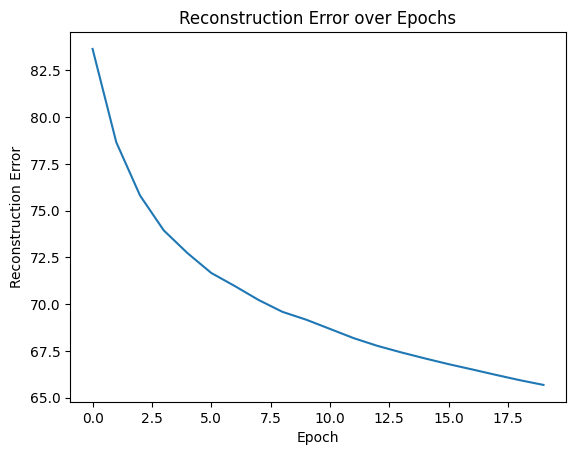

In [13]:
plot_reconstruction_error(rbm.error_history)


In [26]:
def show_reconstructed_images_changed(digit, num_images):
   
    """ Showwing the reconstructed images from the given digit, digit can be different """ 
    
    images = train_X[train_y==digit]

    # Sampling images from all
    sample_indices = np.random.choice(images.shape[0], num_images, replace=False)
    samples_to_recon = images[sample_indices]
    samples_to_recon = samples_to_recon.reshape(num_images, -1)
    reconstructed = rbm.reconstruct_data(samples_to_recon)
    
    fig, axes = plt.subplots(2, num_images, figsize=(16, num_images))
    
    for i in range(num_images):
        axes[0][i].imshow(samples_to_recon[i].reshape(28, 28), cmap='gray');
        axes[0][i].axis('off')
        axes[0][i].set_title(f"Original {i+1}")
        
        axes[1][i].imshow(reconstructed[i].reshape(28, 28), cmap='gray');
        axes[1][i].axis('off')
        axes[1][i].set_title(f"Reconstructed {i+1}")


def show_reconstruct_of_digits(num_images):
    
    """ Show reconstruction of all digits on a RBM """
    
    fig, axes = plt.subplots(10, num_images, figsize=(11, 18))
    
    for i in range(10):
        images = train_X[train_y==i]
        sample_indices = np.random.choice(images.shape[0], num_images, replace=False)
        samples_to_recon = images[sample_indices]
        samples_to_recon = samples_to_recon.reshape(num_images, -1)
        reconstructed = rbm.reconstruct_data(samples_to_recon)
        
        for j in range(num_images):
            axes[i][j].imshow(samples_to_recon[j].reshape(28, 28), cmap='gray');
            axes[i][j].axis('off')
            axes[i][j].set_title(f"Original {i}")
            
            axes[i][j].imshow(reconstructed[j].reshape(28, 28), cmap='gray');
            axes[i][j].axis('off')
            axes[i][j].set_title(f"Reconstructed {i}")
        
def show_reconstructed_binarized(num_images = 5):
    
    """ Binarize some images in the training set after reconstruction and shows them """
    
    # reconstruct num_images random images from the training set
    #reconstructed_images = rbm.reconstruct_data(np.random.choice(train_X_digit, num_images))
    reconstructed_images = rbm.reconstruct_data(train_X_digit[:num_images])
    
    binarized_images = binarize_reconstructed(reconstructed_images)

    fig, axes = plt.subplots(2, num_images, figsize=(8, 5))
    
    for i in range(num_images):
        axes[0][i].imshow(train_X_digit[i].reshape(28, 28), cmap='gray');
        axes[0][i].axis('off')
        axes[0][i].set_title(f"Original {i+1}")
        
        axes[1][i].imshow(binarized_images[i].reshape(28, 28), cmap='gray');
        axes[1][i].axis('off')
        axes[1][i].set_title(f"Reconstructed {i+1}")

def show_reconstruction(digit):
    
    """ Shows single digit and reconstruct a random """

    images = train_X[train_y==digit]


    # Sampling a image from all
    sample_to_recon = images[np.random.choice(images.shape[0], 1, replace=False)]
    sample_to_recon = sample_to_recon.reshape(1, -1)
    reconstructed = rbm.reconstruct_data(sample_to_recon)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    axes[0].imshow(sample_to_recon.reshape(28, 28), cmap='gray');
    axes[0].axis('off')
    axes[0].set_title(f"Original")
    
    axes[1].imshow(reconstructed.reshape(28, 28), cmap='gray');
    axes[1].axis('off')
    axes[1].set_title(f"Reconstructed")
    

def plot_reconstruction_error(error):
    
    """ Plot error during training (MSE) """ 
    
    plt.plot(error)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.title("Reconstruction Error over Epochs")
    plt.show()


def visualize_weights():
    
    """ Visualizing weights of RBM after training """

    if np.sqrt(rbm.weights.shape[0]) % 1 == 0:
        x_len = int(np.sqrt(rbm.weights.shape[0]))
        y_len = int(np.sqrt(rbm.weights.shape[0]))  
    else:
        x_len = 8
        y_len = rbm.weights.shape[0]//x_len        

    fig, axes = plt.subplots(x_len, y_len, figsize=(13, 11))
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(rbm.weights[i].reshape(28, 28), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
     

# Reconstructing different digits

The model is trained on a digit in this case but what happens if we try to reconstruct a different digits, for example the features that are being learn for the 8s are somewhat similar to the 2s in some cases in others maybe not, but for very simple digits like the number 1 it gets reconstruct well also if the digit is not the same as we trained, usually ones are just lines, very basic shapes.
Of course the numbers that gets reconstructed this way present some feature of the number in the weights of the RBM we trained on.

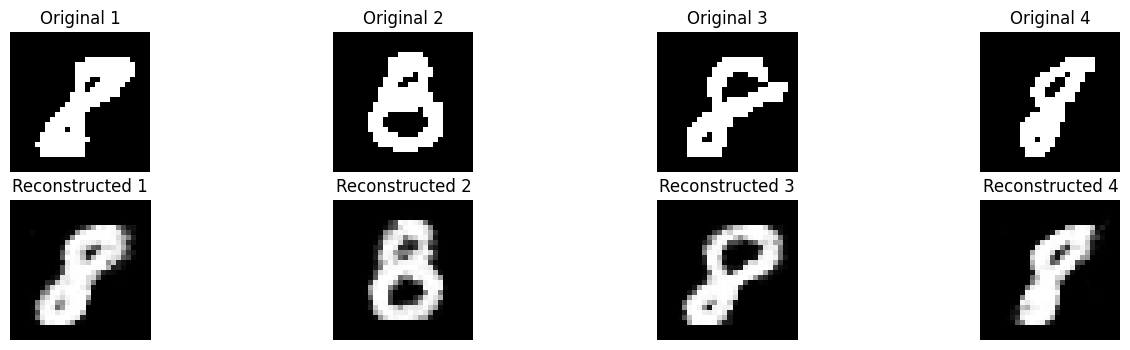

In [14]:
show_reconstructed_images_changed(digit=8, num_images=4)

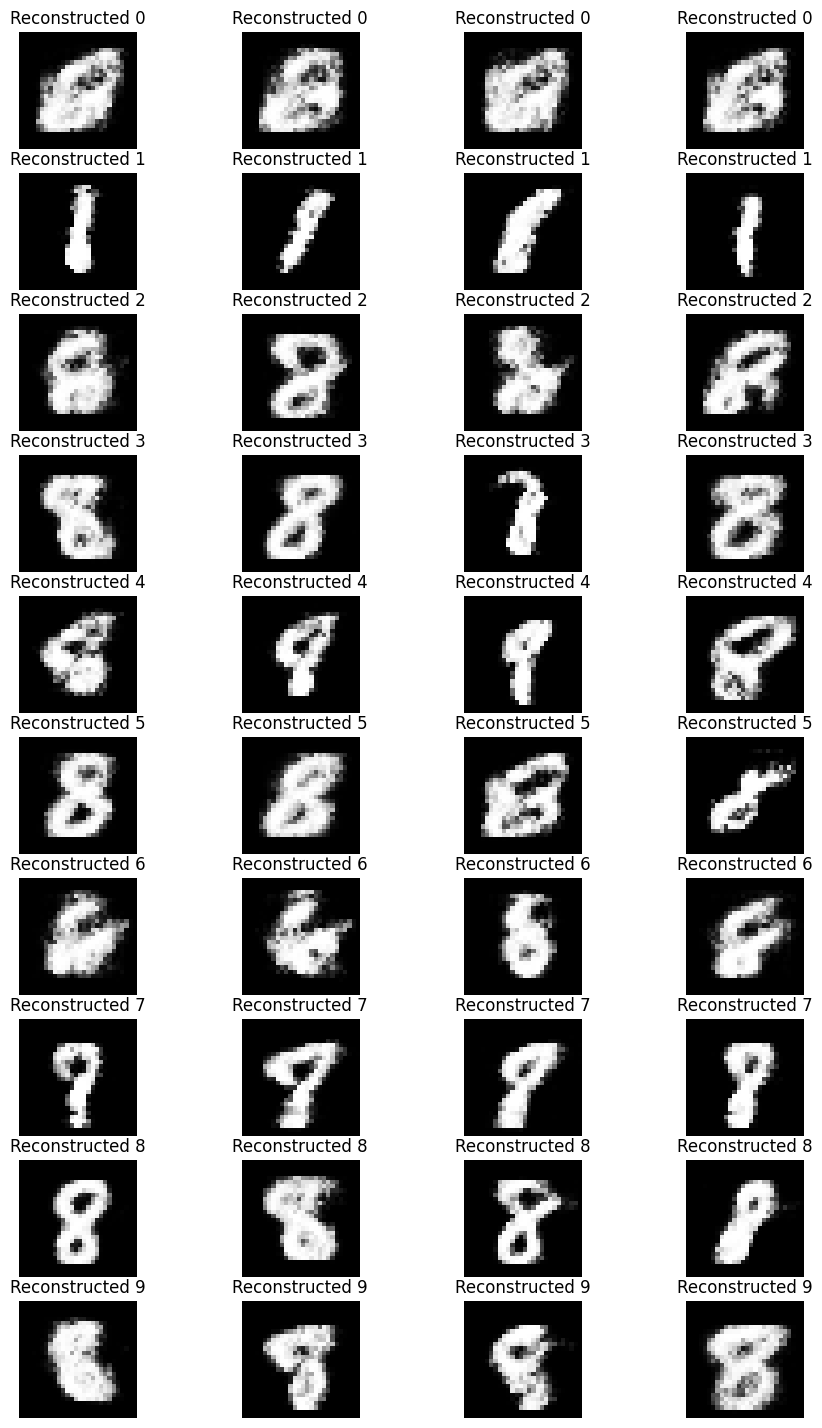

In [15]:
show_reconstruct_of_digits(num_images=4)

In [16]:
# again binarizing reconstructed images
def binarize_reconstructed(reconstructed_images, threshold=0.5):

    binarized_reconstructed_images = []

    # Keep original reconstructed images
    reconsturcted_images_to_binarize = reconstructed_images.copy()

    for reconstructed in reconsturcted_images_to_binarize:
        reconstructed[reconstructed > threshold] = 1
        reconstructed[reconstructed < threshold] = 0
        binarized_reconstructed_images.append(reconstructed)

    return binarized_reconstructed_images 

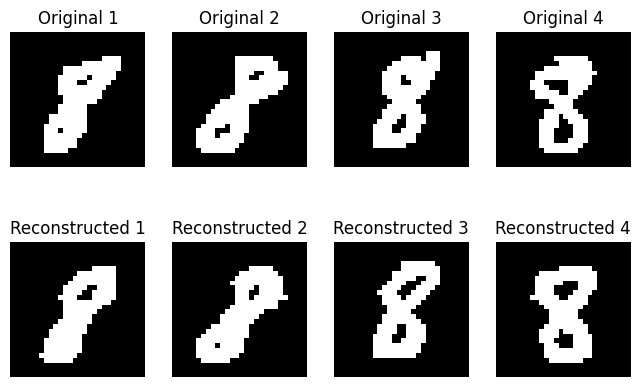

In [27]:
show_reconstructed_binarized(num_images=4)


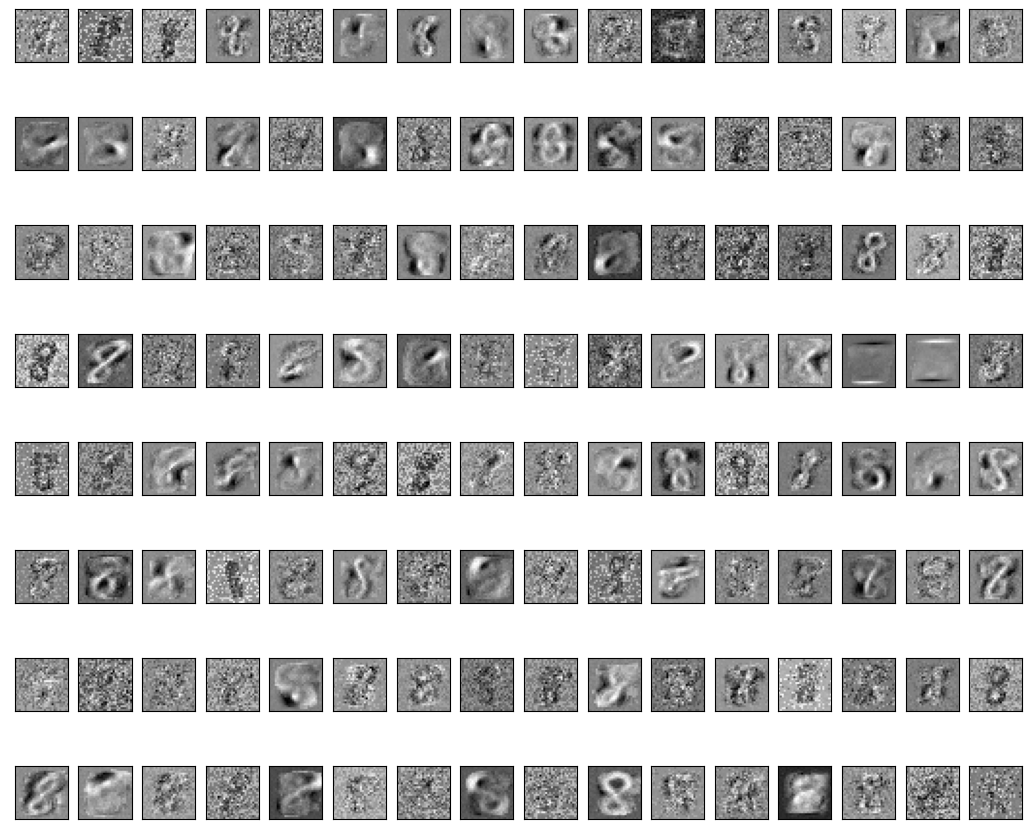

In [18]:
visualize_weights()

# Reconstruction evaluation of RBM

To evaluate the reconstruction quality we can use different techniques like MSE, PSNR, SSIM[], etc. In this case we will use the MSE (Mean Squared Error) and the SSIM (Structural Similarity Index Measure). The MSE is defined as: 

$$MSE = \frac{1}{N}\sum_{i=1}^{N} (x_i - y_i)^2$$

where $x$ is the original image and $y$ is the reconstructed image. The SSIM is defined as:

$$
SSIM = \frac{(2\mu_x\mu_y + C_1)(2\sigma_{xy} + C_2)}{(\mu_x^2 + \mu_y^2 + C_1)(\sigma_x^2 + \sigma_y^2 + C_2)}
$$

the parameters $\mu_x, \mu_y$ and $\sigma_x, \sigma_y$ are the mean and standard deviation of the original and reconstructed images, respectively. The parameters $\sigma_{xy}$ and $\sigma_{yx}$ are the covariance between the original and reconstructed images. The parameters $C_1$ and $C_2$ are constants that are used to stabilize the division by zero.

Why SSIM? 

From scikit-image documentation: When comparing images, the mean squared error (MSE)–while simple to implement–is not highly indicative of perceived similarity. Structural similarity aims to address this shortcoming by taking texture into account

In the docs there is a citation of the original paper that explains the SSIM in more detail.

Basically the idea behind SSIM approach is that human system is adapted to extract information from visual scenes. With an algorithm we can try to mimic this process. For example SSIM take the index of similarity on three things : **Local patch luminance**, **local patch contrast**, **local patch structure**. Is a more penalizing but accurate measure of similarity, near the human perception.

From the paper in the paragraph of structural similarity: **"Thus, it is relevant that the cluster of natural images occupies an extremely tini portion in the image space. This provides strong prior information about what original image should look like, a precious source of information for design of a similarity measure, in computational neuroscience has loong been hypotesized that visual system is highly adapted to the natura visual environment, not in terms of short-term adaptation ability but also trough long term neural evolution and developement."**




In [29]:
from sklearn.metrics import accuracy_score, classification_report, recall_score
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

In [31]:
def rbm_evaluation(num_images=10,threshold=0.6):
    SHOW = False
    """ 
    Using sklearn.metric we will see how much two images reconstructed are similar by looking at each pixel if is 1-0 comparing images
    So we will reconstruct then show only the ones in the images that are activated for a threshold value like 0.5 or 0.6.
    
    returns: prints evaluation metrics for the RBM
    """

    accuracy_score_list = []
    recall_score_list = []
    ssim_score_list = []
    mean_squared_error_list = []
    
    recons = []
    
    to_recons = test_X_digit[np.random.choice(test_X_digit.shape[0], num_images, replace=False)]
 
    for data in to_recons:
        recons.append(rbm.reconstruct_data(data))    
        
    # Binarize reconstructed images
    binarized_recons = binarize_reconstructed(recons, threshold=threshold)
    
    # Show the data
    if SHOW:

        for i in range(num_images):
            fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
            axes[0].imshow(to_recons[i].reshape(28, 28), cmap='gray');
            axes[0].axis('off')
            axes[0].set_title(f"Original")
    
            axes[1].imshow(binarized_recons[i].reshape(28, 28), cmap='gray');
            axes[1].axis('off')
            axes[1].set_title(f"Reconstructed")

      
    recons = np.array(recons).reshape(-1, 28*28)
    to_recons = np.array(to_recons).reshape(-1, 28*28)
    
    # Evaluation metrics
    for i in range(num_images):
        accuracy_score_list.append(accuracy_score(to_recons[i], binarized_recons[i]))
        recall_score_list.append(recall_score(to_recons[i], binarized_recons[i]))
        ssim_score_list.append(ssim(to_recons[i], binarized_recons[i], data_range=1))
        mean_squared_error_list.append(mean_squared_error(to_recons[i], binarized_recons[i]))
    
    print(f"Accuracy Score: {np.mean(accuracy_score_list)}")
    print(f"Recall Score: {np.mean(recall_score_list)}")
    print(f"SSIM Score: {np.mean(ssim_score_list)}")
    print(f"Mean Squared Error: {np.mean(mean_squared_error_list)}")
    
    
    
    

# Parameter of reconstruction

After the reconstruct we set a parameter threshold to evaluate the reconstruction on a binarized image and then we evaluate how much is good. Depending on the parameter we can have bigger accuracy score or bigger recall score. The value that seems to fit better is 0.4 for our threshold.

Seeing the SSIM score at 0.81 we can say that the reconstruction is pretty good. 
Accuracy being 0.93 is not that good but we got a recall of 0.92 


In [44]:
rbm_evaluation(num_images=test_X_digit.shape[0], threshold=0.4)

Accuracy Score: 0.9362925868499351
Recall Score: 0.922448355273593
SSIM Score: 0.8119347441344362
Mean Squared Error: 0.06370741315006495


# RBM as denoisers

Spoking with a collegue i discovered as well that RBM can do denoising on noisy images, so the idea is not originally mine but i wanted to try and show it here.

Text(0.5, 0.98, 'Adding gaussian noise')

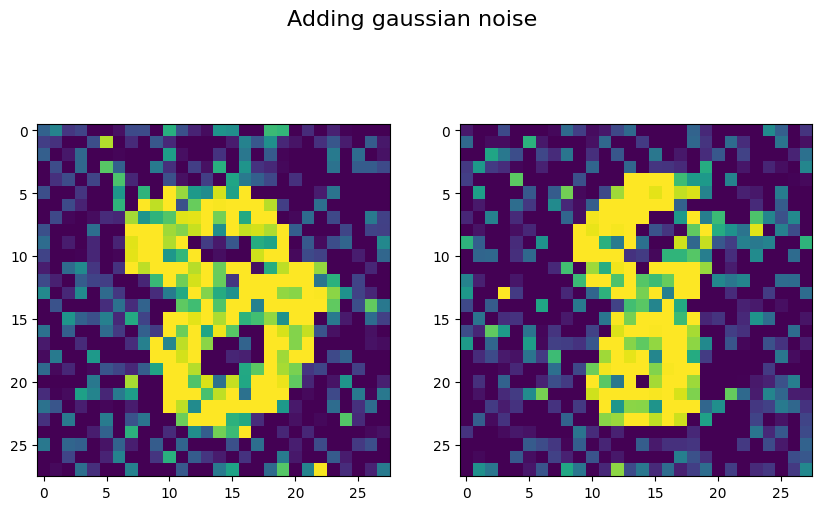

In [65]:
noise = 0.3

test_X_noise = test_X + noise * np.random.normal(loc=0.0, scale=1.0, size=test_X.shape)
test_X_noise = np.clip(test_X_noise, 0., 1.)


fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for ax in axs.flatten():
    ax.imshow(test_X_noise[test_y==8][np.random.randint(0, test_X[test_y == 8].shape[0])].reshape(28, 28))

fig.suptitle("Adding gaussian noise", fontsize=16)


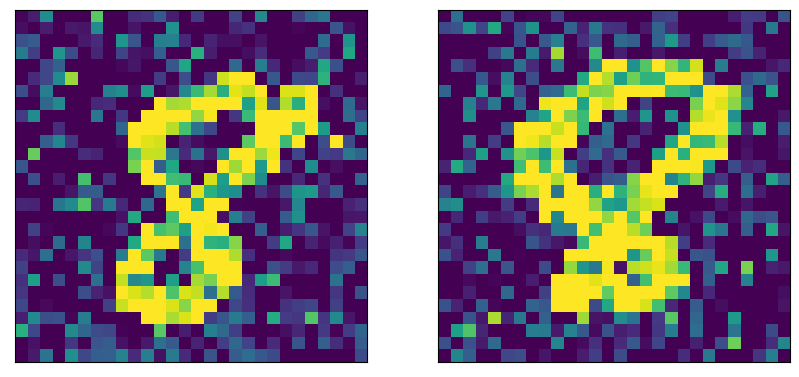

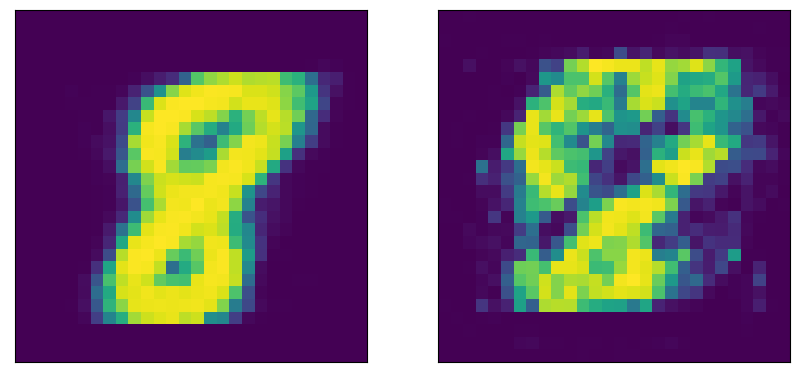

In [64]:
# Denoising RBM
# Take some example from test_X_noise and show the denoised images

# 4 images with noise
samples_noisy = test_X_noise[test_y==8][np.random.randint(0, test_X[test_y == 8].shape[0], size=2)] 

# Show noisy images
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

for i,ax in enumerate(axs.flatten()):
    # first we get image
    samples_noisy = samples_noisy.reshape(-1, 28*28)
    ax.imshow(samples_noisy[i].reshape(28, 28))
    ax.set_xticks([])
    ax.set_yticks([])


fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# show the denoise of the images just above
for i,ax in enumerate(axs.flatten()):
    # first we get image
    samples_noisy = samples_noisy.reshape(-1, 28*28)
    ax.imshow(rbm.reconstruct_data(samples_noisy[i]).reshape(28, 28))
    ax.set_xticks([])
    ax.set_yticks([])

# Conclusions and future works

In conclusion we can say that RBM can be used for image reconstruction and denoising, the reconstruction of the digits is pretty good and the denoising of the images is also pretty good. I think that the reconstruction can be improved by using a more complex model like a deep belief network or a convolutional RBM. Also we had to learn only one digit per RBM, it would be interesting to see if we can learn more digits at the same time and see if the reconstruction is better or not.

Hinton said in the paper explaining that this model can be parallelized, in fact it takes a lot of time to train on my laptop, a further improvement could be to make a version with minibatches that runs in parallel.

## Intresting connection with hebbian learning

During researches for implementing the RBM i've discovered a lot about different models like the `Ising Model`, these models present some connection with the `Restricted Boltzmann Machines` from the point of view of the temperature in fact both models use the concept of the Boltzmann distribution to model the probability of different states. 

The Ising Model is a mathematical model that is used to describe the behavior of magnetic materials. It consists of a lattice of spins, which can be either up or down, and an energy function that depends on the interaction between neighboring spins. The probability distribution over all possible configurations of spins is given by the Boltzmann distribution.

And then we have `Hopefield nets`, the latter are very intresting because can store **memories** in their weights much like the RBM we've just seen,but with a different approach.

The Hopfield nets are a type of artificial neural network which a basic idea behind the Hopfield nets is to use a set of interconnected neurons to store patterns or memories. Each neuron in the network is connected to every other neuron, and the strength of the connection between two neurons is represented by a weight.

To store a pattern in the network, the weights between neurons are adjusted so that when an input pattern is presented to the network, it will settle into a stable state that corresponds to the stored pattern. The network can then be used to recognize similar patterns or to find optimal solutions to optimization problems.

One advantage of Hopfield nets over RBMs is that they are deterministic. This makes them easier to interpret and analyze than probabilistic models like RBMs.



# References

[Hinton guide to RBMs](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf), Geoffrey Hinton


Paper for SSIM: Mean Squared Error: Love it or Leave it? A New Look at Signal Fidelity Measures